# Assignment 1 - Group 3
### Carl Anton Schmidt (s204154), Julius H. Radzikowski (s204162)

Link to our [repository](https://github.com/radziko/CompSocSci/)

Contributions were as follows:

     - Julius PART X

     - Carl PART X

# Formalia:

Please read the [assignment overview page](https://laura.alessandretti.com/comsocsci2023/assignments.html) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Mar 28th at 23:59. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Assignment, Assignment 2)_. 

Remember to include in the first cell of your notebook:
* the link to your group's Git repository (if you don't have a shared Git repository, it's fine. Remember to do it next time)
* group members' contributions

# Part 1: Mixing Patterns and Assortativity

Let's dig in and try to understand more about the network of Computational Social Scientists using more advanced features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below. For the exercises below, you shall use the network you built in [Week 4](https://github.com/lalessan/comsocsci2023/blob/main/lectures/Week4.ipynb).


> **Exercise 1: Mixing Patterns and Assortativity.** 
>
> * For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.
> * Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.
> * Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?
> * Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? (__Hint__: See [this paper](https://nbviewer.org/github/suneman/socialgraphs2019/blob/master/lectures/Week5.ipynb), eq (2)). **Important**: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.    
> * Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.
> * _Optional:_ Estimate the gender of each author from their name, using the [World Gender Name Dictionary](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/MSEGSJ). Repeat the analysis above to study the assortativity of the network by gender rather than by field. What do you observe?


# Exercise 1 - solution

We start with our imports, and opening our network file:

In [288]:
import numpy as np 
import networkx as nx
import pandas as pd
import pickle
from netwulf import visualize
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

file = open("CSS_field.pkl", "rb")
G = pickle.load(file)
file.close()

We check for number of edges and nodes:

In [3]:
print(G.number_of_edges())
print(G.number_of_nodes())

321151
12087


We grab the fields, and check for 'unknown':

In [4]:
fields = nx.get_node_attributes(G, 'field')
sum(np.array(list(fields.values())) == 'unknown')/len(list(fields.values()))

0.05361131794489948

We see that about 5% of the fields are unknown. Those will be removed:

In [5]:
former_size = G.size()

def remove_unknown(G):
    fields = nx.get_node_attributes(G, 'field')
    unknown_att_nodes = []
    for node in G.nodes:
        if fields[node] == 'unknown':
            unknown_att_nodes.append(node)
    G.remove_nodes_from(unknown_att_nodes)

In [6]:
remove_unknown(G)

In [7]:
print('Size went from ', former_size, 'to',  G.size(), 'removed' , former_size - G.size(), 'edges')

Size went from  321151 to 311564 removed 9587 edges


We now grab the field they work in, and compute the number of nodes that have an identical top field:

In [8]:
fracs = []
for node in G.nodes:
    if fields[node] != 'unknown':
        c = 0
        for neighbor in G.neighbors(node):
            if fields[neighbor] == fields[node]:
                c += 1
        fracs.append(c/G.degree(node))

The mean across the array is printed:

In [9]:
mean_fracs = np.mean(fracs)
print(mean_fracs)

0.6907467838027441


So, the average person in the network has 69% of their connected nodes working in the same top field.

We define a function to replace the top field of each author randomly.
This returns the average as well.

In [10]:
def random_field(G):
    fields = nx.get_node_attributes(G, 'field')
    for key in fields.keys():
        fields[key] = random.choice(list(fields.values()))
    
    fracs = []
    for node in G.nodes:
        if fields[node] != 'unknown':
            c = 0
            for neighbor in G.neighbors(node):
                if fields[neighbor] == fields[node] and fields[neighbor]:
                    c += 1
            fracs.append(c/G.degree(node))
    return np.mean(fracs)

In [11]:
random_field(G)

0.13773930365992712

For one randomized graph, the average is 13,2%

We now repeat 100 times:

In [50]:
list_of_fracs = []
for i in range(100):
    list_of_fracs.append(random_field(G))

print(np.mean(list_of_fracs))

0.13930051431368418


For 100 repititions, the average is also 13,9%.
So it's definitely different from 69%, which means they're not as likely to by chance get the same top field.

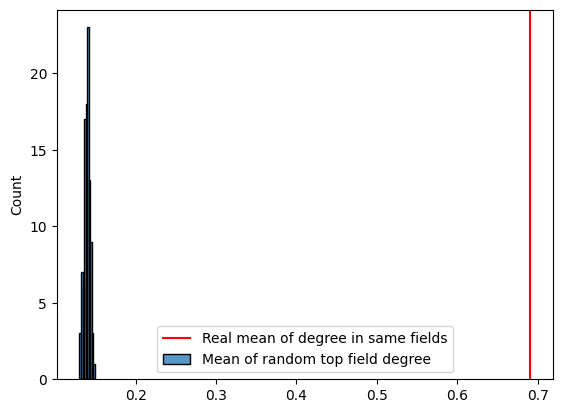

In [84]:
sns.histplot(list_of_fracs, label='Mean of random top field degree')
plt.axvline(mean_fracs, c='red', label='Real mean of degree in same fields')
plt.legend()

We can also see on the distribution, that it is quite far away from the actual value when the fields are not shuffled.

Now we look at the assortativity coefficient:

In [13]:
# First calculate the assortivity matrix (not in percentage yet)
def matrix_assort_field(G):
    """Returns a nested dictionary"""
    
    fields = nx.get_node_attributes(G, 'field')
    fields_list = set(list(fields.values()))
    assortativity = {key: [] for key in fields_list}

    #For each node append its neighbours field according to the nodes field
    for node in G.nodes:
        field = fields[node]
        for nei in G.neighbors(node):
            assortativity[field].append(fields[nei])

    # For each of the fields, count the occurances of the other fields being a neighbour
    for felt in fields_list:
        listCount = []
        for innerfelt in fields_list:
            listCount.append(assortativity[felt].count(innerfelt))
        assortativity[felt] = dict(zip(list(fields_list), listCount))
    
    return assortativity

In [14]:
dicto = matrix_assort_field(G)
dfMatrix = pd.DataFrame.from_dict(dicto) / pd.DataFrame.from_dict(dicto).sum().sum() 
# to percent / divide by total number nodes
M = np.array(dfMatrix)
assort = (np.trace(M) - np.sum(M.sum(axis=0)**2))/(1- np.sum(M.sum(axis=0)**2))
print('Own calculated assorttivity coefficient:', assort)

Own calculated assorttivity coefficient: 0.8132264753614445


For fun, let's compare to the NetworkX implementation:

In [15]:
nx.attribute_assortativity_coefficient(G, 'field')

0.8132264753614445

They're identical.

Now we look at the degree assortivity:

In [22]:
def node_degrees(graph):
    nodes = set(graph)
    x_degree = y_degree = graph.degree()

    lx = []
    ly = []

    for n, deg_n in x_degree(nodes):
        neighbours = (neighbour for _, neighbour in graph.edges(n) if neighbour in nodes)
        for _, deg_m in y_degree(neighbours):
            
            lx.append(deg_n)
            ly.append(deg_m)

    return scipy.stats.pearsonr(lx, ly)[0]

In [21]:
node_degrees(G)

0.9240340575078011

We see that we have a quite high degree assortivity, which means that high-degree nodes are very likely to be connected to other high-degree nodes - and low-degree nodes to other low-degree nodes.
An explanation of this could be, that it is probable that the leading scientists in the field all work together - whilst lesser known, and/or more up-and-coming researchers are probably also working together. This could be bachelors, masters or PHD students for example, they probalby won't be as well connected as the leading researchers.

We compare it to the networkx implementation:

In [19]:
nx.degree_assortativity_coefficient(G)

0.9240340575078221

They're also identical.

We unfortunately did not have names in this graph, and will not be performing the optional part.

# Part 2: Communities

> __Exercise 2: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 
>
> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>
> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
> 3. Explain in your own words the concept of _modularity_. 
> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.
> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement the _double edge swap_ algorithm. The _double edge swap_ algorithm is quite old... it was implemented in 1891 (!) by Danish mathematician Julius Petersen(https://en.wikipedia.org/wiki/Julius_Petersen). Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network.
>       * __b.__ Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
>       * __c.__ If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
>       * Repeat steps __b.__ and __c.__ to achieve at least N swaps (I suggest N to be larger than the number of edges).
> 6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.
> 7. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.
> 8. Compute the average and standard deviation of the modularity for the random network.
> 9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 
> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?
> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?
> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

> __Exercise 3__: Community detection on the network of Computational Social Scientists. 
>
> * Consider the network you built in [Week 4](https://github.com/lalessan/comsocsci2023/blob/main/lectures/Week4.ipynb).
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * If you are curious, you can also try the *Infomap* algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in [advanced topics 9B](http://networksciencebook.com/chapter/9#advanced-9b).
> * Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their _community_. Describe the structure you observe.
> * Make sure you save the assignment of authors to communities.


# Part 3: TF-IDF.


> __Exercise 4: TF-IDF and the Computational Social Science communities.__ The goal for this exercise is to find the words charachterizing each of the communities of Computational Social Scientists.
> What you ned for this exercise: 
>    * The assignment of each author to their network community, and the degree of each author (Week 6, Exercise 4). This can be stored in a dataframe or in two dictionaries, as you prefer.  
>    * the tokenized _abstract_ dataframe (Week 7, Exercise 2)
>
> 1. First, check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF. 
>   * What does TF stand for? 
>   * What does IDF stand for?
> 2. Now, we want to find out which words are important for each *community*, so we're going to create several ***large documents, one for each community***. Each document includes all the tokens of abstracts written by members of a given community. 
>   * Consider a community _c_
>   * Find all the abstracts of papers written by a member of community _c_.
>   * Create a long array that stores all the abstract tokens 
>   * Repeat for all the communities. 
> __Note:__ Here, to ensure your code is efficient, you shall exploit ``pandas`` builtin functions, such as [``groupby.apply``](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html) or [``explode``](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html).
> 3. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the __top 5 communities__ (by number of authors). 
>   * Describe similarities and differences between the communities.
>   * Why aren't the TFs not necessarily a good description of the communities?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?
> 4. We're ready to calculate TF-IDF. Do that for the __top 9 communities__ (by number of authors). Then for each community: 
>   * List the 10 top TF words 
>   * List the 10 top TF-IDF words
>   * List the top 3 authors (by degree)
>   * Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?


Explanation of TF-IDF: 

We import our communities DF and our tokenized abstracts DF:

In [128]:
communities = pd.read_parquet('communities.parquet')
communities = communities.astype(int)
communities.columns = ['authorIds', 'community', 'degree']
tokens = pd.read_parquet('abstracts_tokenized.parquet')

In [109]:
communities.head(2)

,authorIds,community,degree
0,1409288721,8,69
1,1844994,8,74


In [110]:
tokens.head(2)

,paperId,abstract,authorIds,tokens,bigrams
0,167273526caeae8439b2c08630f984b758f76dab,"There is growing concern about ""algorithmic bi...","['50197963', '3371403', '2062143', '88738815']","[there, growing, concern, algorithmic, bias, p...","[[there, growing], [growing, concern], [concer..."
1,cb3d482fa29075ed3305f11016056661c0d999e0,Preventing discrimination requires that we hav...,"['50197963', '3371403', '3171769', '2062143']","[preventing, discrimination, requires, means, ...","[[preventing, discrimination], [discrimination..."


Looking at our DF's, we have one with the authors and their communities, and one with the papers and all their tokens.
Let's combine them.

In [129]:
#Explode by authorIds:
tokens.authorIds = tokens.authorIds.apply(eval)
tokens = tokens.explode('authorIds')
tokens.authorIds = tokens.authorIds.apply(int)

In [130]:
tokens = tokens.merge(communities, on='authorIds')
tokens.head(2)

,paperId,abstract,authorIds,tokens,bigrams,community,degree
0,167273526caeae8439b2c08630f984b758f76dab,"There is growing concern about ""algorithmic bi...",50197963,"[there, growing, concern, algorithmic, bias, p...","[[there, growing], [growing, concern], [concer...",8,7
1,cb3d482fa29075ed3305f11016056661c0d999e0,Preventing discrimination requires that we hav...,50197963,"[preventing, discrimination, requires, means, ...","[[preventing, discrimination], [discrimination...",8,7


In [355]:
tokens.head(2)

,paperId,abstract,authorIds,tokens,bigrams,community,degree
0,167273526caeae8439b2c08630f984b758f76dab,"There is growing concern about ""algorithmic bi...",50197963,"[there, growing, concern, algorithmic, bias, p...","[[there, growing], [growing, concern], [concer...",8,7
1,cb3d482fa29075ed3305f11016056661c0d999e0,Preventing discrimination requires that we hav...,50197963,"[preventing, discrimination, requires, means, ...","[[preventing, discrimination], [discrimination...",8,7


Now we have a big dataframe with all our date, we get the token lists:

In [357]:
tokens.tokens = tokens.tokens.apply(list)
tokens_community = pd.DataFrame(tokens.groupby('community', as_index=False))

In [358]:
tokens_community = tokens.groupby('community').apply(lambda x: x.drop_duplicates(subset=["paperId"])["tokens"].sum())

In [360]:
tokens_dict = {k: v for k, v in tokens_community.items()}

In [362]:
def TermFrequency(tokens):
    """Calculate the term frequency for a list of tokens"""
    tf_dict = {}
    for token in tokens:
        if token in tf_dict:
            tf_dict[token] += 1
        else:
            tf_dict[token] = 1
    return tf_dict

> __Exercise 5: The Wordcloud__. It's time to visualize our results!
> * Install the [`WordCloud`](https://pypi.org/project/wordcloud/) module. 
> * Now, create word-cloud for each community. Feel free to make it as fancy or non-fancy as you like.
> * Make sure that, together with the word cloud, you print the names of the top three authors in each community (see my plot above for inspiration). 
> * Comment on your results. What can you conclude on the different sub-communities in Computational Social Science? 
> * Look up online the top author in each community. In light of your search, do your results make sense?